In [1]:
# Skin Lesion Detection Using Densenet

In [2]:
# Importing Library

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


In [4]:
#Importing Data

In [5]:
ben_dir = "./data/train/benign"
malig_dir = "./data/train/malignant"

train_dir = "./data/train/"
test_dir = "./data/test/"

In [6]:
# Showing Randomly Selected image from each class

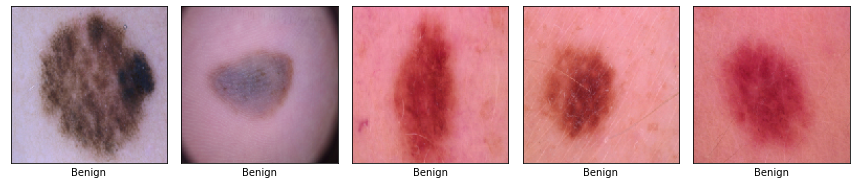

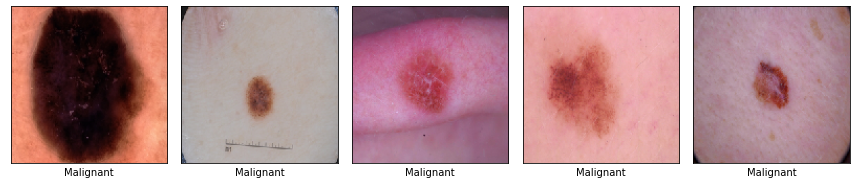

In [7]:
import random
import os
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt


def display_images(directory):
    """
    Displays 5 random images from the given directory.
    
    Args:
    - directory: A string representing the path of the directory containing images.
    """
    images = random.sample(os.listdir(directory), 5)
    plt.figure(figsize=(12, 7))
    for i, img in enumerate(images):
        path = os.path.join(directory, img)
        img = load_img(path, target_size=(150, 150))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if 'benign' in directory.lower():
            plt.xlabel("Benign")
        elif 'malig' in directory.lower():
            plt.xlabel("Malignant")
    plt.tight_layout()


# Display 5 random images from benign directory
display_images(ben_dir)

# Display 5 random images from malignant directory
display_images(malig_dir)

In [8]:
# Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Flowing the data from the directory
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32
)

test_data = val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    class_mode="binary",
    batch_size=32
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [10]:
# Images after Data Augmentation

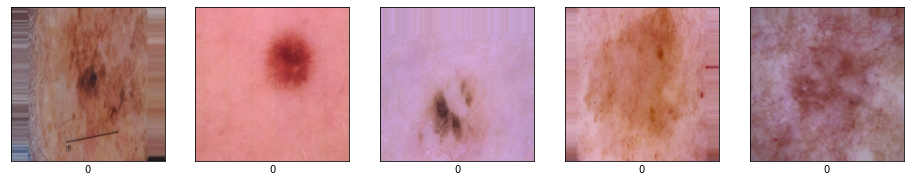

In [11]:
from tensorflow.keras.preprocessing import image


def display_samples(train_data):
    """
    Display a set of image samples from the given train_data generator.
    
    Args:
    train_data: An image generator object.
    """
    sample_x, sample_y = next(train_data)
    plt.figure(figsize=(16, 9))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.img_to_array(sample_x[i])
        plt.imshow(img)
        plt.xlabel(np.argmax(sample_y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

#display images 
display_samples(train_data)

In [12]:
#Importing Densenet (Transfer Learning)

In [13]:
from tensorflow.keras.applications import DenseNet121

# Define DenseNet121 model
dense = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


In [14]:
# Disable training for the first 121 layers of the dense neural network.
for layer in dense.layers[:121]:
    layer.trainable = False

In [15]:
# Importing Sequention And Creating Model

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
)

# Create the Sequential model
model = Sequential()

# Add the DenseNet layer to the model
model.add(dense)

# Add the MaxPooling2D layer to the model
model.add(MaxPooling2D())

# Add the BatchNormalization layer to the model
model.add(BatchNormalization())

# Add the Flatten layer to the model
model.add(Flatten())

# Add the Dense layer with sigmoid activation to the model
model.add(Dense(512, activation="sigmoid"))

# Add the Dropout layer with a rate of 0.5 to the model
model.add(Dropout(0.5))

# Add the final Dense layer with sigmoid activation to the model
model.add(Dense(1, activation="sigmoid"))


In [18]:
# Briefing out Model Created

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1024)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 1024)       4096      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                                 
 dropout (Dropout)           (None, 512)              

In [20]:
# Importing and creating evaluatiion metrics like TP,TN,FN,Recall,Precision,Accuracy and F1 Score

In [21]:
# Import necessary libraries
import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score, MatthewsCorrelationCoefficient
from tensorflow.keras.optimizers import Adam

# Define list of metrics to be used
metrics = [
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    F1Score(num_classes=1, name='f1'),
    MatthewsCorrelationCoefficient(num_classes=1, name='mc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp')
]

# Define learning rate and compile the model
lr = 0.0001
model.compile(optimizer=Adam(lr=lr), loss="binary_crossentropy", metrics=metrics)


c:\python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# Early stopping Setup (if our model stops improving we stop learing at early stage)

In [23]:
# Set up the variables for the callbacks
patience: int = 1
stop_patience: int = 3
factor: float = 0.3

# Create the list of callbacks
callbacks = [
    # Save the best model to a file
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose=0),
    # Reduce learning rate when validation loss stops improving
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]


In [24]:
# Fitting Model (Training)

In [25]:
# Trains the model and returns the history of the training process.
# train_data: The data to train the model.
# test_data: The data to validate the model.
# epochs: The number of epochs to train the model for.
# verbose: Verbosity mode (0 = silent, 1 = progress bar).
# callbacks: List of callbacks to apply during training.
def train_model(train_data, test_data, epochs=15, verbose=1, callbacks=None):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks
    )
    return history

history = train_model(train_data, test_data, epochs=15, verbose=1, callbacks=callbacks)

Epoch 1/15
83/83 [==============================] - 174s 2s/step - loss: 0.4098 - accuracy: 0.8138 - precision: 0.7981 - recall: 0.7895 - f1: 0.6244 - mc: 0.0000e+00 - tp: 945.0000 - tn: 1201.0000 - fn: 252.0000 - fp: 239.0000 - val_loss: 0.3894 - val_accuracy: 0.8136 - val_precision: 0.9447 - val_recall: 0.6267 - val_f1: 0.6250 - val_mc: 0.0000e+00 - val_tp: 188.0000 - val_tn: 349.0000 - val_fn: 112.0000 - val_fp: 11.0000 - lr: 1.0000e-04
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8787 - precision: 0.8707 - recall: 0.8605 - f1: 0.6244 - mc: 0.0000e+00 - tp: 1030.0000 - tn: 1287.0000 - fn: 167.0000 - fp: 153.0000
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
83/83 [==============================] - 82s 981ms/step - loss: 0.2683 - accuracy: 0.8787 - precision: 0.8707 - recall: 0.8605 - f1: 0.6244 - mc: 0.0000e+00 - tp: 1030.0000 - tn: 1287.0000 - fn: 167.0000 - fp: 153.0000 - val_loss: 0.4128 - val_accuracy: 0.

In [26]:
# Evaluation of model on Test set

In [27]:
model.evaluate(test_data)

21/21 [==============================] - 5s 242ms/step - loss: 0.2432 - accuracy: 0.9030 - precision: 0.8907 - recall: 0.8967 - f1: 0.6250 - mc: 0.0000e+00 - tp: 269.0000 - tn: 327.0000 - fn: 31.0000 - fp: 33.0000


[0.2431698590517044,
 0.903030276298523,
 0.8907284736633301,
 0.8966666460037231,
 array([0.625], dtype=float32),
 0.0,
 269.0,
 327.0,
 31.0,
 33.0]

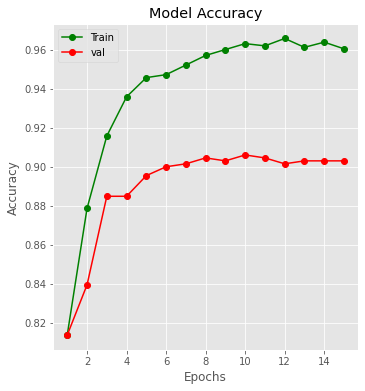

In [29]:
#Plotting Epochs Vs Accuracy

# Set ggplot style
plt.style.use("ggplot")

# Create figure with size 12x6 inches
fig = plt.figure(figsize=(12,6))

# Define x-axis as range from 1 to 15 (not inclusive)
epochs = range(1, 16)

# Create subplot with 1 row, 2 columns, and select the first plot
plt.subplot(1, 2, 1)

# Plot accuracy values for training data in green circles connected by solid line
plt.plot(epochs, history.history["accuracy"], "go-")

# Plot accuracy values for validation data in red circles connected by solid line
plt.plot(epochs, history.history["val_accuracy"], "ro-")

# Add title and axis labels
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Add legend with labels "Train" and "val" in upper left corner
plt.legend(["Train", "val"], loc="upper left")

# Display plot
plt.show()


In [30]:
# Plotting Loss Vs Epochs

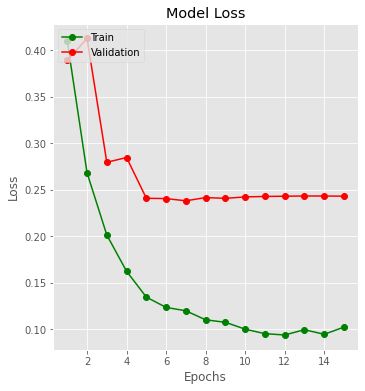

In [31]:
def plot_loss(history):
    """
    Plot model loss for each epoch.

    Args:
        history (keras.callbacks.History): History object containing training metrics.

    Returns:
        None.
    """
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(12, 6))
    epochs = range(1, 16)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["loss"], "go-", label="Train")
    plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.show()

plot_loss(history)

In [33]:
# Prepare the dataset for confusion metrix and evaluation 

IMG_SIZE = (224, 224)
BATCH_SIZE = 700


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary')
# Get the next batch of images from the test generator
x_test, y_test = next(test_generator)

# Predict the classes of the testing data
y_pred = model.predict(x_test)
for i in range(len(y_pred)):
    if(y_pred[i]>=0.5):
        y_pred[i]=1
    else:
        y_pred[i]=0
# print(y_pred)

Found 660 images belonging to 2 classes.
21/21 [==============================] - 6s 210ms/step


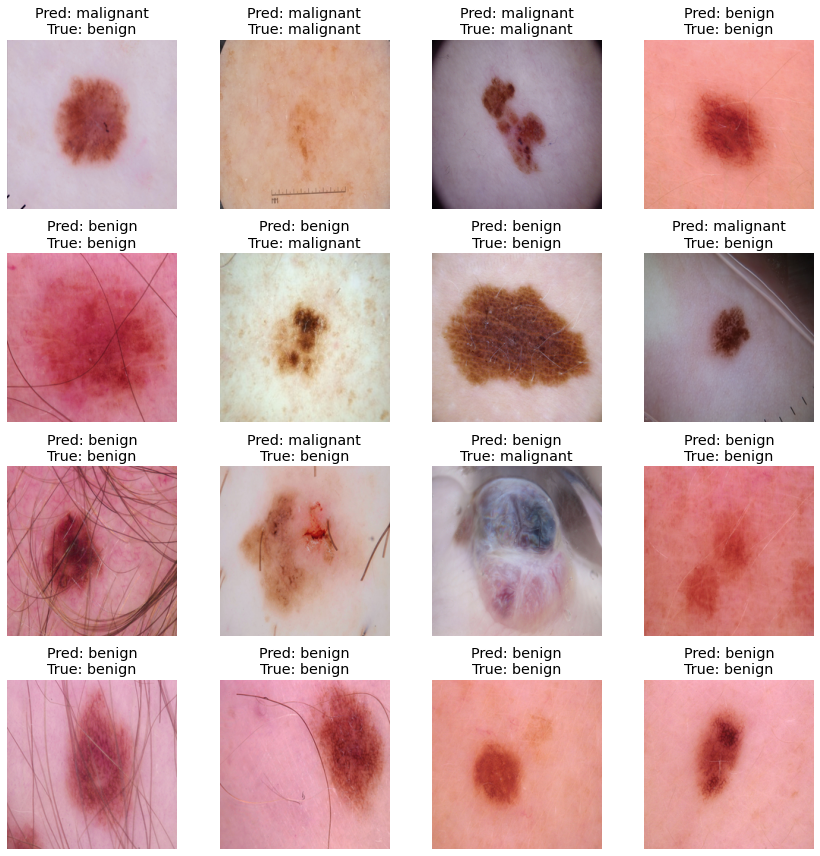

In [34]:
# Flatten predicted and true class arrays
y_pred_classes = y_pred.flatten()
y_true_classes = y_test.flatten()

# Dictionary to map labels
label_dict = {0: 'benign', 1: 'malignant'}

# Plot the images along with their predicted and actual labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    pred_label = label_dict[y_pred_classes[i]]
    true_label = label_dict[y_true_classes[i]]
    ax.set_title("Pred: {}\nTrue: {}".format(pred_label, true_label))
    ax.axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


In [35]:
# Creating Confusion Matrix To Summarize performance

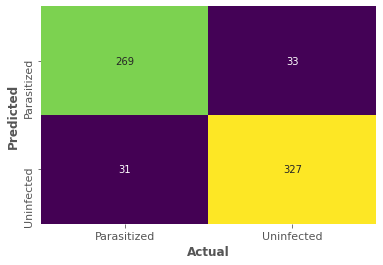

In [36]:
import seaborn as sns

# Confusion matrix data
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], 
           [history.history['val_fn'][-1], history.history['val_tn'][-1]]]

# Create a heatmap with the confusion matrix
sns.heatmap(cm_data, annot=True, cmap='viridis', cbar=False, fmt='g')

# Set the labels and ticks for the heatmap
plt.xticks([0.5, 1.5], ["Parasitized", "Uninfected"], fontsize=11)
plt.yticks([0.5, 1.5], ["Parasitized", "Uninfected"], fontsize=11)
plt.xlabel("Actual", fontsize=12, fontweight="bold")
plt.ylabel("Predicted", fontsize=12, fontweight="bold")

# Display the heatmap
plt.show()